-----
<div> <center> ESPACIO PARA BANNER DE LA MAESTRIA </center> </div>   

-----

# Clusteres espaciales

El contenido de este notebook es tomado del siguiente [enlace](https://darribas.org/gds_scipy16/). Para más información visitar las referencias

Nuevamente usaremos los datos de AirBnb en Austin, pero esta vez nos adentraremos en el tópico de regresión espacial.

La premisa básica de los ejercicios que haremos en este cuaderno es que a través de las características de las casas listadas en AirBnb podemos aprender sobre la geografía de Austin. En concreto, intentaremos clasificar los códigos postales de la ciudad en un número reducido de grupos que nos permitan extraer algunos patrones sobre los principales tipos de casas y zonas de la ciudad.

En caso de que tenga problemas instalando `pysal` le recomendamos ejecutar el comando:

```conda install --channel conda-forge pysal```

Ahí podrá ver si existen incopatibilidades entre los paquetes. De no tener alguna, se instalará correctamente. En caso de sí tener podrá revisarlas para hacer los ajustes correspondientes. Si la cantidad de incompatibilidades es grande, es buena idea crear un nuevo ambiente desde cero y volver a correr el comando mencionado arriba.


In [70]:
# Carguemos unas librerías iniciales

%matplotlib inline

import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysal as ps
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import scale

sns.set(style="whitegrid")

## Datos

Definimos el directorio de nuestros datos. Esta línea debe ajustarla para la ruta particular de su computador

In [71]:
abb_link = './data/listings.csv.gz'
zc_link = './data/Zipcodes.geojson'

In [72]:
# Cargamos datos
lst = pd.read_csv(abb_link)

Los datos originales están en inglés por lo que haremos uso del siguiente diccionario para transformar el nombre de las variables a español.

In [73]:
diccionario = {
    'bedrooms': 'alcobas', 
    'bathrooms': 'baños', 
    'beds': 'camas',
    'property_type': 'tipos_propiedad'
}

In [74]:
# Renombramos las variables
lst = lst.rename(diccionario, axis = 1)

Los datos están a niveles individuales. Por ende vamos a agregarlos a niveles de barrios y areas. Para esta ejercicio usaremos el siguiente subconjunto de variables que describen las principales características de las propiedades.

In [75]:
variables = ['alcobas', 'baños', 'camas']

Como estas variables son numéricas las agregaremos con la media a nivel de barrios.

In [76]:
promedios = lst.groupby('zipcode')[variables].mean()
promedios.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 47 entries, 33558.0 to 78759.0
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcobas  47 non-null     float64
 1   baños    47 non-null     float64
 2   camas    47 non-null     float64
dtypes: float64(3)
memory usage: 1.5 KB


Adicionalmente, quisiéramos incluir una noción de los tipos de inmuebles que existen. Este tipo de variables categóricas las dummyficaremos para posteriormente hacer una suma y dejar un conteo simple del número de tipos por area y construir proporciones.

In [77]:
# Ahora vamos a traducir a español los tipos de propiedad a partir del siguiente diccionario
diccionario_tipos_propiedad = {
    "House": "Casa",
    "Camper/RV": "Casa rodante",
    "Bed & Breakfast": "Cama y desayuno",
    "Apartment": "Apartamento",
    "Townhouse": "Casa adosada",
    "Condominium": "Condominio",
    "Bungalow": "Bungalow",
    "Cabin": "Cabaña",
    "Other": "Otro",
    "Loft": "Desván",
    "Villa": "Villa",
    "Treehouse": "Casa en el árbol",
    "Tent": "Carpa",
    "Boat": "Bote",
    "Hut": "Choza",
    "Chalet": "Chalet",
    "Earth House": "Casa de Tierra",
    "Tipi": "Tipi"
}

lst['tipos_propiedad'] = lst['tipos_propiedad'].replace(diccionario_tipos_propiedad)

In [78]:
tipos = pd.get_dummies(lst['tipos_propiedad'])
tipos_agregados = tipos.join(lst['zipcode']).groupby('zipcode').sum()
proporcion_tipos = (tipos_agregados * 100.).div(tipos_agregados.sum(axis = 1), axis = 0)
proporcion_tipos.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 47 entries, 33558.0 to 78759.0
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Apartamento       47 non-null     float64
 1   Bote              47 non-null     float64
 2   Bungalow          47 non-null     float64
 3   Cabaña            47 non-null     float64
 4   Cama y desayuno   47 non-null     float64
 5   Carpa             47 non-null     float64
 6   Casa              47 non-null     float64
 7   Casa adosada      47 non-null     float64
 8   Casa de Tierra    47 non-null     float64
 9   Casa en el árbol  47 non-null     float64
 10  Casa rodante      47 non-null     float64
 11  Chalet            47 non-null     float64
 12  Choza             47 non-null     float64
 13  Condominio        47 non-null     float64
 14  Desván            47 non-null     float64
 15  Otro              47 non-null     float64
 16  Tipi              47 non-null    

Combinando ambas bases

In [79]:
df = promedios.join(proporcion_tipos)
df.head()

,alcobas,baños,camas,Apartamento,Bote,Bungalow,Cabaña,Cama y desayuno,Carpa,Casa,...,Casa de Tierra,Casa en el árbol,Casa rodante,Chalet,Choza,Condominio,Desván,Otro,Tipi,Villa
zipcode,,,,,,,,,,,,,,,,,,,,,
33558.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78610.0,1.0,1.0,1.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78620.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78652.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78660.0,1.0,1.0,1.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora que todas nuestras variables son numéricas y continuas, vamos a proceder a estandarizarlas para poder realizar nuestro algoritmo de segmentación.

In [80]:
df_est = pd.DataFrame(scale(df), index = df.index, columns = df.columns) \
    .rename(lambda x: str(int(x)))
df_est.head()

,alcobas,baños,camas,Apartamento,Bote,Bungalow,Cabaña,Cama y desayuno,Carpa,Casa,...,Casa de Tierra,Casa en el árbol,Casa rodante,Chalet,Choza,Condominio,Desván,Otro,Tipi,Villa
zipcode,,,,,,,,,,,,,,,,,,,,,
33558,-3.147103,-1.259873,-1.524576,-1.108614,-0.147442,-0.288636,-0.308775,-0.276983,-0.270496,1.390836,...,-0.147442,-0.242924,-0.341365,-0.147442,-0.147442,-0.519145,-0.565121,-0.550776,-0.147442,-0.18793
78610,-1.180096,-1.259873,-1.524576,2.738584,-0.147442,-0.288636,-0.308775,-0.276983,-0.270496,-2.236517,...,-0.147442,-0.242924,-0.341365,-0.147442,-0.147442,-0.519145,-0.565121,-0.550776,-0.147442,-0.18793
78620,-1.180096,-1.259873,-0.001761,-1.108614,-0.147442,-0.288636,-0.308775,5.793836,-0.270496,-2.236517,...,-0.147442,-0.242924,-0.341365,-0.147442,-0.147442,-0.519145,-0.565121,-0.550776,-0.147442,-0.18793
78652,-1.180096,-1.259873,-1.524576,-1.108614,-0.147442,-0.288636,-0.308775,-0.276983,-0.270496,1.390836,...,-0.147442,-0.242924,-0.341365,-0.147442,-0.147442,-0.519145,-0.565121,-0.550776,-0.147442,-0.18793
78660,-1.180096,-1.259873,-1.524576,2.738584,-0.147442,-0.288636,-0.308775,-0.276983,-0.270496,-2.236517,...,-0.147442,-0.242924,-0.341365,-0.147442,-0.147442,-0.519145,-0.565121,-0.550776,-0.147442,-0.18793


Ahora visualizamos el mapa de la ciudad

In [81]:
os.listdir("data")

['Density Estimation. Histogram and KDE.pdf',
 'listings.csv.gz',
 'Zipcodes.geojson']

<AxesSubplot:>

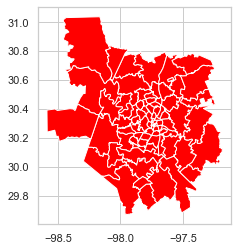

In [82]:
zc = gpd.read_file(zc_link)
zc.plot(color = 'red')

Vamos a combinar ambas bases

In [83]:
zdb = zc[['geometry', 'zipcode', 'name']].join(df_est, on = 'zipcode').dropna()

Mostramos las áreas que se perdieron por no tener datos

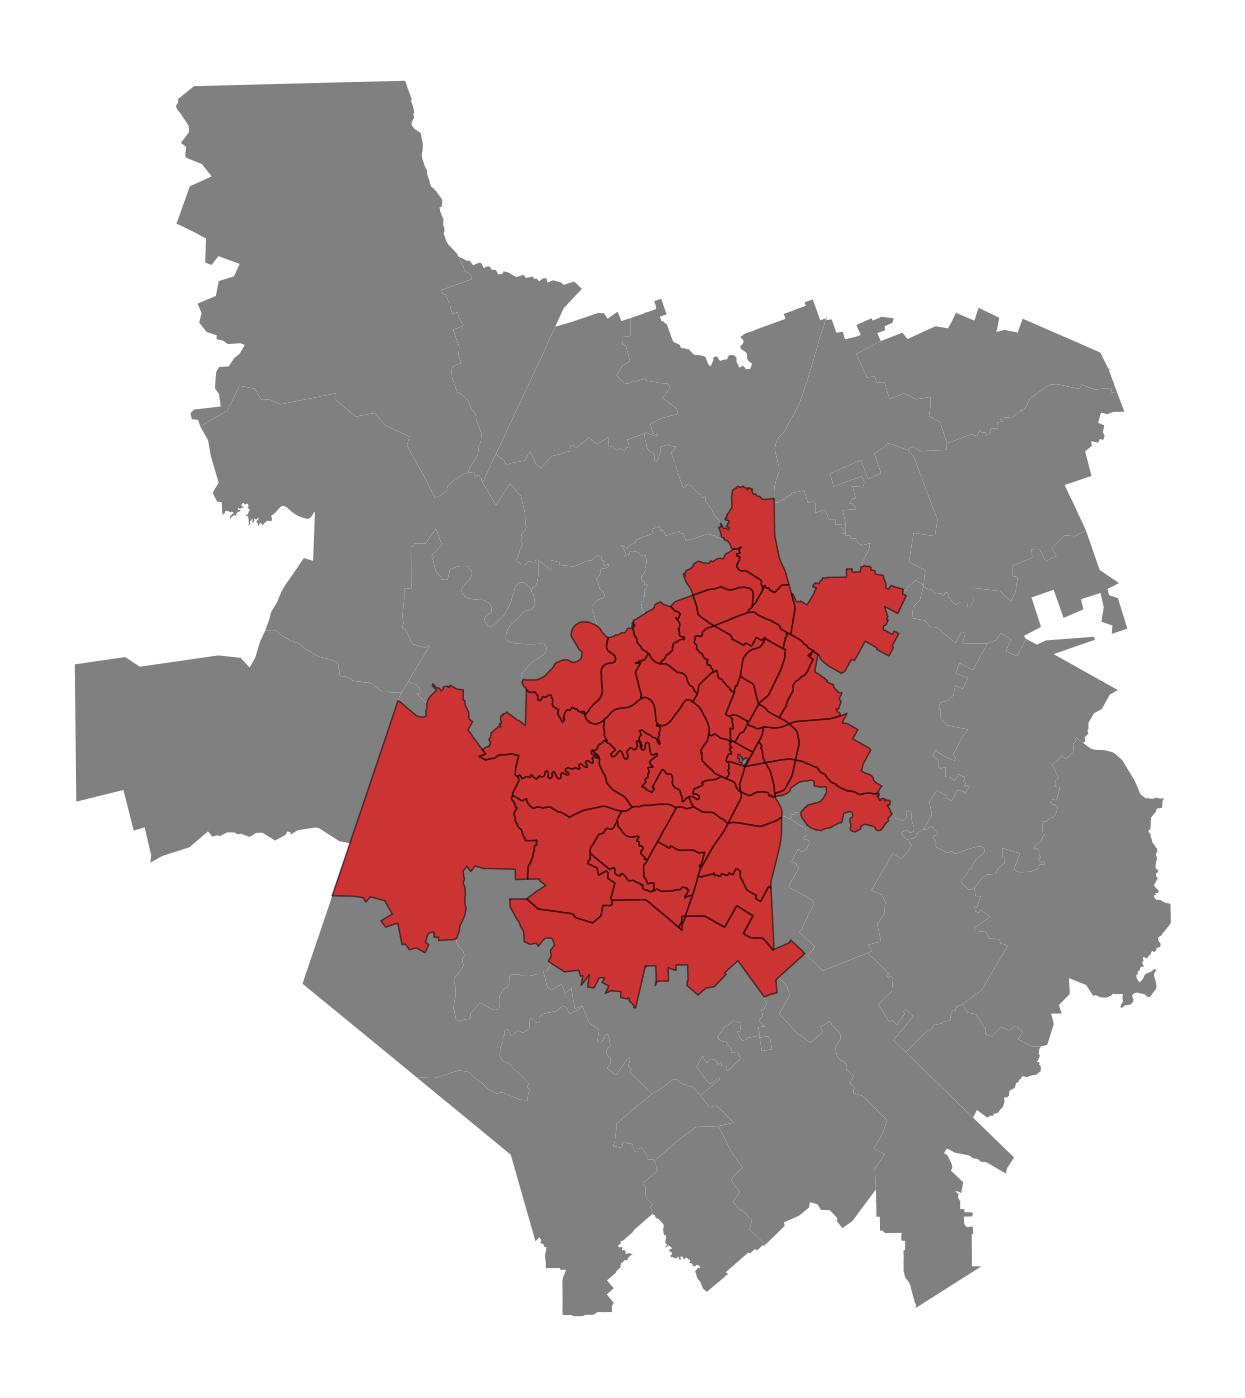

In [84]:
f, ax = plt.subplots(1, figsize = (9, 9), dpi = 200)

zc.plot(color = 'grey', linewidth = 0, ax = ax)
zdb.plot(color = 'red', linewidth = 0.5, ax = ax, edgecolor = 'black', alpha = 0.6)

ax.set_axis_off()

plt.show()

## Análisis geodemográfico
La intuición principal detrás del análisis geodemográfico es agrupar áreas dispares de una ciudad o región en un pequeño conjunto de clases que capturen varias características compartidas por aquellos en el mismo grupo. Al hacer esto, podemos obtener una nueva perspectiva no solo sobre los tipos de áreas en una ciudad, sino también sobre cómo se distribuyen en el espacio. En el contexto de nuestro análisis de datos de AirBnb, la idea es que podamos agrupar diferentes códigos postales de Austin según el tipo de inmuebles listadas en la web. Esto nos dará una pista sobre la geografía de AirBnb en la capital tecnológica de Texas.

Aunque existen muchas técnicas para agrupar estadísticamente las observaciones en un conjunto de datos, todas ellas parten de la premisa de utilizar un conjunto de atributos para definir clases o categorías de observaciones que son similares dentro de cada una de ellas, pero difieren entre grupos. Cómo se define la similitud dentro de los grupos y la diferencia entre ellos y cómo se opera el algoritmo de clasificación es lo que hace que las técnicas difieran y también lo que hace que cada una de ellas sea particularmente adecuada para problemas o tipos de datos específicos. Como ilustración, usaremos K-medias, que es probablemente la técnica más utilizada para la agrupación estadística.

In [85]:
# A continuación se muestra la documentación del método
cluster.KMeans?

Init signature:
cluster.KMeans(
    n_clusters=8,
    *,
    init='k-means++',
    n_init=10,
    max_iter=300,
    tol=0.0001,
    verbose=0,
    random_state=None,
    copy_x=True,
    algorithm='auto',
)
Docstring:     
K-Means clustering.

Read more in the :ref:`User Guide <k_means>`.

Parameters
----------

n_clusters : int, default=8
    The number of clusters to form as well as the number of
    centroids to generate.

init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
    Method for initialization:

    'k-means++' : selects initial cluster centers for k-mean
    clustering in a smart way to speed up convergence. See section
    Notes in k_init for more details.

    'random': choose `n_clusters` observations (rows) at random from data
    for the initial centroids.

    If an array is passed, it should be of shape (n_clusters, n_features)
    and gives the initial centers.

    If a callable is passed, it s

In [86]:
# Arbitrariamente vamos a escoger 5 clusteres.
# Se inicializa el método
km5 = cluster.KMeans(n_clusters = 5)
# Se ajusta a los datos
km5cls = km5.fit(zdb.drop(['geometry', 'name'], axis = 1).values)

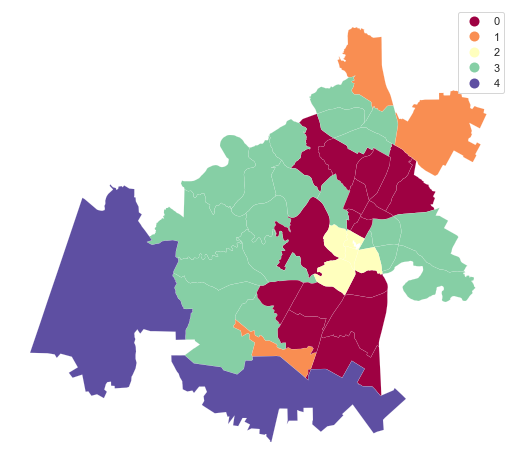

In [87]:
f, ax = plt.subplots(1, figsize=(9, 9))

zdb.assign(cl = km5cls.labels_).plot(column = 'cl', categorical = True, 
    legend = True, 
    linewidth = 0.1, edgecolor = 'white', ax = ax, cmap = "Spectral")

ax.set_axis_off()

plt.show()

Esto nos da una buena idea de la estructura geográfica, pero no nos dice mucho sobre cuáles son los elementos que definen a estos grupos. Para ello, podemos echar un vistazo a las características de las clases. Por ejemplo, veamos cómo se distribuye la proporción de diferentes tipos de propiedades entre los clústeres:

In [88]:
cl_pcts = proporcion_tipos.rename(lambda x: str(int(x))).reindex(zdb['zipcode']) \
    .assign(cl = km5cls.labels_).groupby('cl').mean()

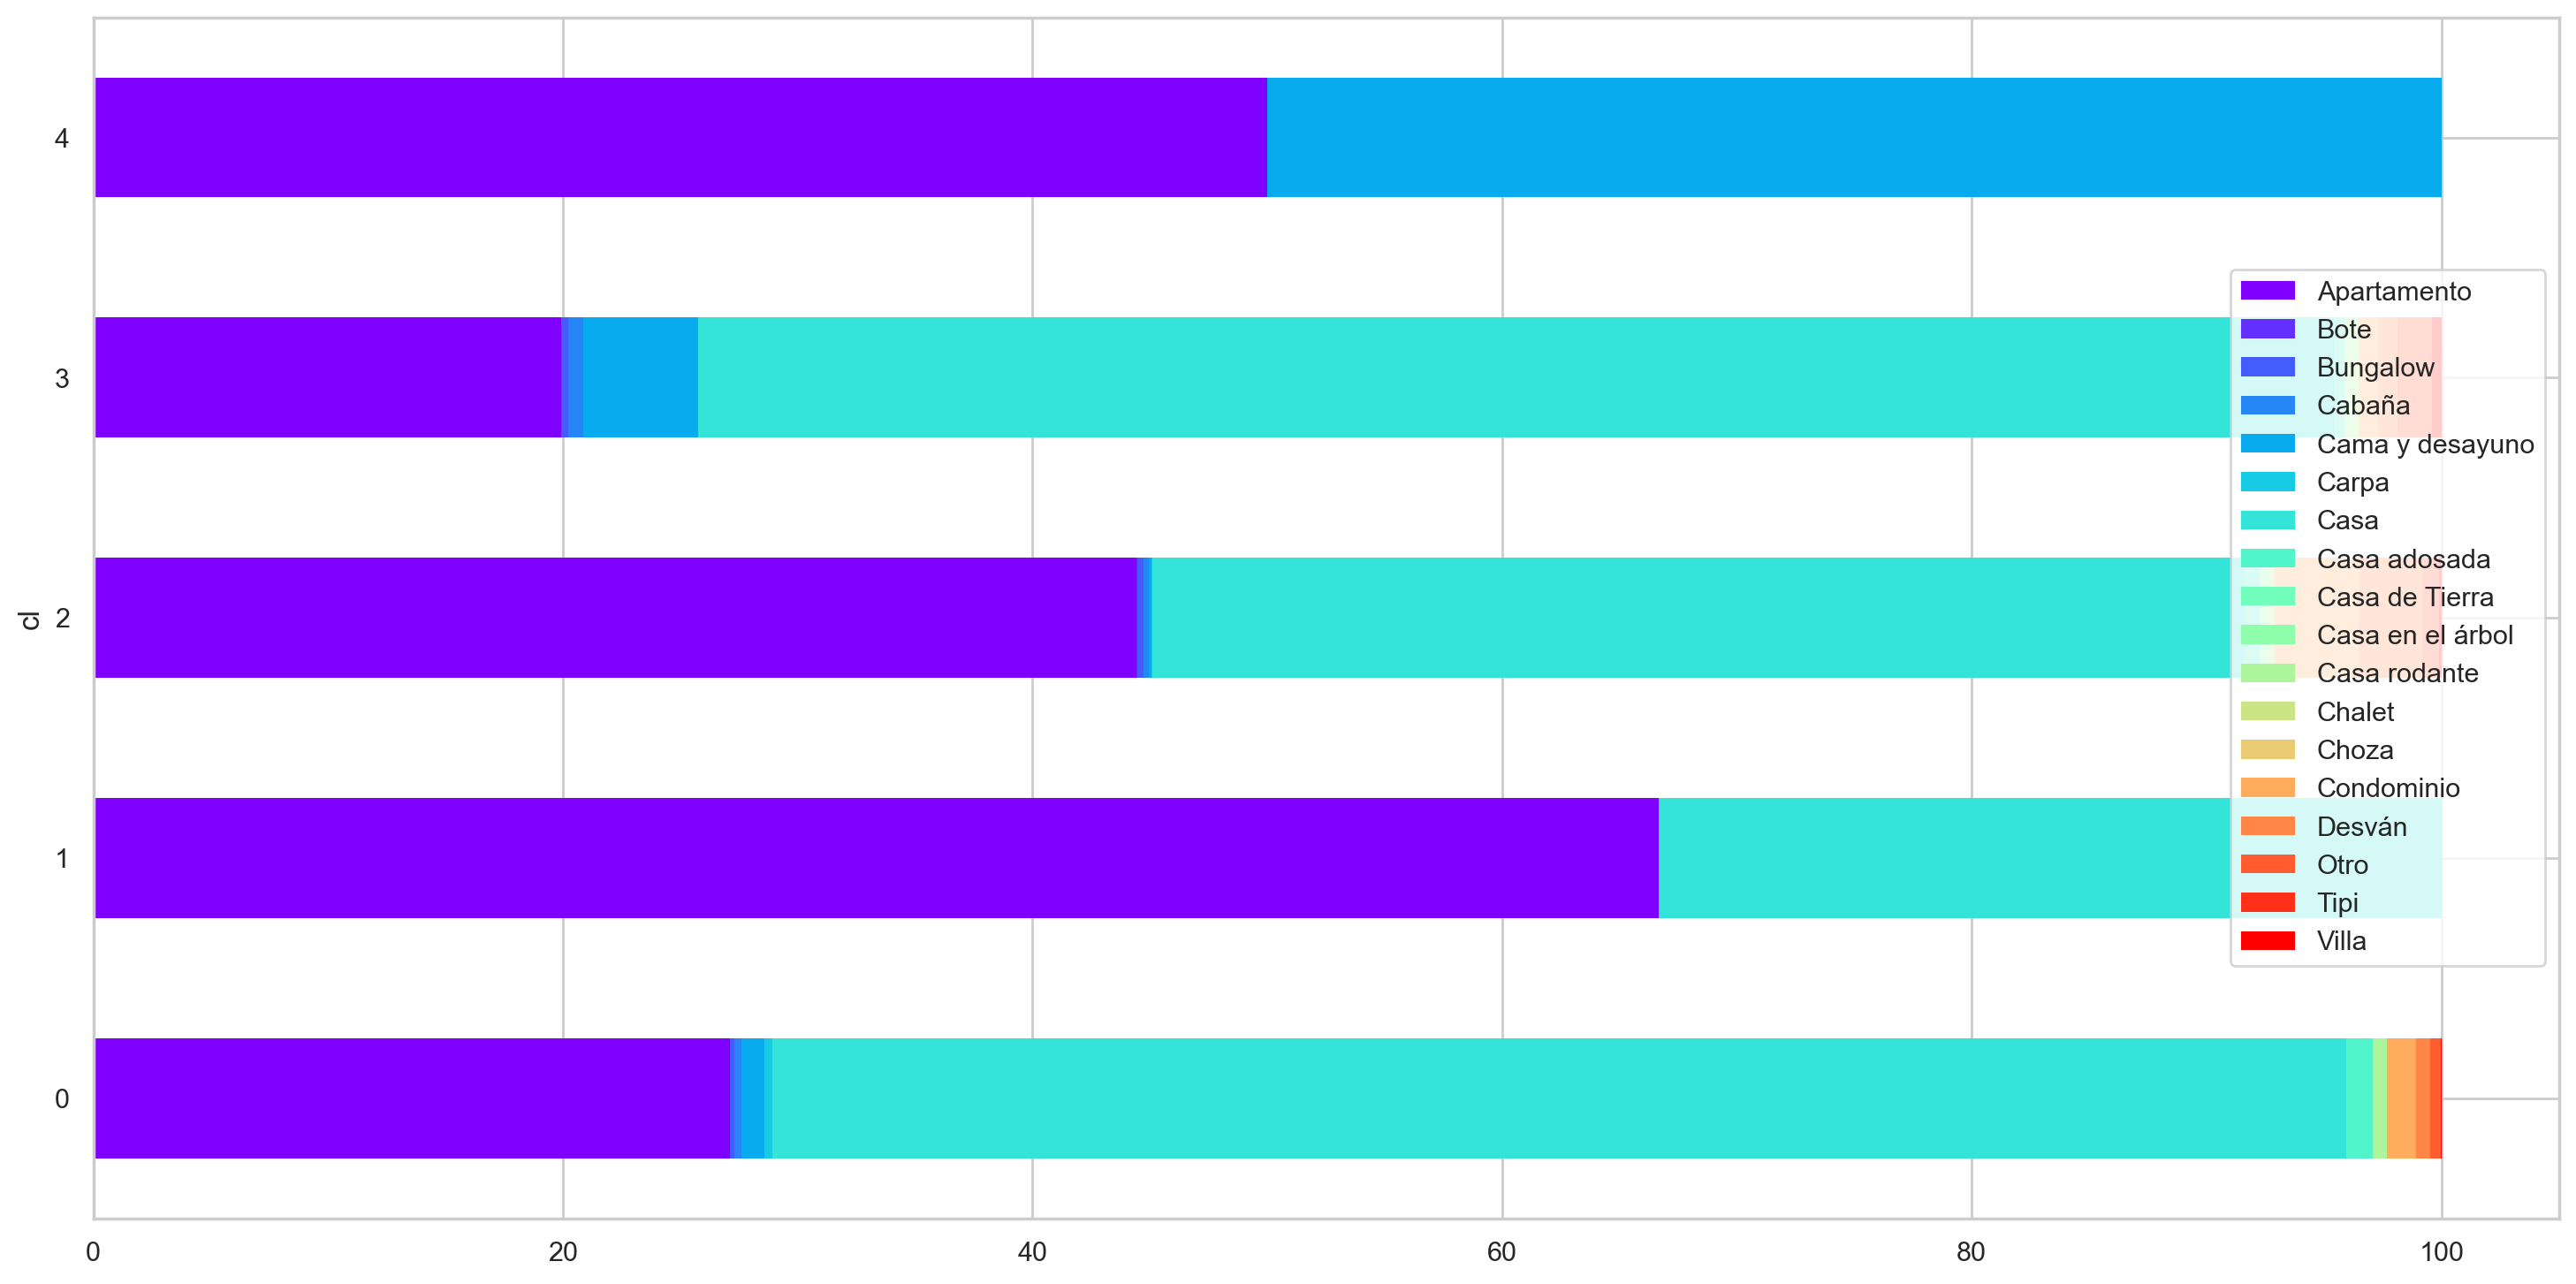

In [89]:
f, ax = plt.subplots(1, figsize = (18, 9), dpi = 200)
cl_pcts.plot(kind = 'barh', stacked = True, ax = ax, cmap = 'rainbow', linewidth = 0)
ax.legend(ncol = 1, loc = "right")

## Análisis de regionalización: construcción de regiones significativas
Existen muchos métodos de regionalización pero en esencia todos implican clustering de observaciones con la restricción de que las observaciones deben ser vecinas geográficas para estar en la misma categoría. Por eso, usaremos el término área para cada observación y región para cada clase o conglomerado.

Como en el caso no espacial, existen muchos algoritmos diferentes para realizar la regionalización, y todos difieren en los detalles relacionados con la forma en que miden la (des)similitud, el proceso para regionalizar, etc. Sin embargo, al igual que antes, todos ellos comparten algunos aspectos comunes. En particular, todos toman un conjunto de atributos de entrada y una representación del espacio en forma de una matriz de ponderaciones espaciales binarias. Según el algoritmo, también podrá requerir el número deseado de regiones de salida en las que se agregan las áreas.

En este ejemplo, vamos a crear agregaciones de códigos postales en grupos que tienen áreas donde las calificaciones de AirBnb sean similares. En otras palabras, crearemos delineaciones para la "calidad" o "satisfacción" de los usuarios de AirBnb. Por ende trazaremos los límites que separan las áreas donde los usuarios de AirBnb tienden a estar satisfechos con su experiencia frente a aquellas donde las calificaciones no son tan altas. Para hacer esto, nos centraremos en el conjunto de variables `review_scores_X` en el conjunto de datos original:

In [90]:
ratings = [i for i in lst if 'review_scores_' in i]
ratings

['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

De manera similar al caso anterior, ahora llevamos los puntajes al nivel del código postal. Dado que todos son puntajes que van de 0 a 100, podemos usar promedios y no necesitamos estandarizar.

In [92]:
promedio_rating = lst.groupby('zipcode')[ratings].mean().rename(lambda x: str(int(x)))

Pegamos esa información con los datos espaciales

In [93]:
zrt = zc[['geometry', 'zipcode']].join(promedio_rating, on='zipcode').dropna()
zrt.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 43 entries, 0 to 78
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   geometry                     43 non-null     geometry
 1   zipcode                      43 non-null     object  
 2   review_scores_rating         43 non-null     float64 
 3   review_scores_accuracy       43 non-null     float64 
 4   review_scores_cleanliness    43 non-null     float64 
 5   review_scores_checkin        43 non-null     float64 
 6   review_scores_communication  43 non-null     float64 
 7   review_scores_location       43 non-null     float64 
 8   review_scores_value          43 non-null     float64 
dtypes: float64(7), geometry(1), object(1)
memory usage: 3.4+ KB


A diferencia de las técnicas de agrupación estándar, la regionalización requiere una representación formal de la topología. De este modo el algoritmo puede imponer restricciones espaciales durante el proceso de agrupamiento de las observaciones. 

Para este caso, usaremos la definición de contigüidad de la reina. 

In [94]:
from libpysal.weights import Queen
w = Queen.from_dataframe(zrt, geom_col = "geometry")

Ahora estamos listos para ejecutar el algoritmo de regionalización. En este caso, usaremos el *max-p* ([Duque, Anselin & Rey, 2011](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1467-9787.2011.00743.x)), que no requiere un número predefinido de regiones de salida, sino que toma una variable de destino para asegurarse de que se alcance un umbral mínimo. En nuestro caso, dado que se basa en calificaciones, impondremos que cada región resultante tenga al menos el 10% del número total de revisiones. Analicemos lo que eso significaría:

In [95]:
n_rev = lst.groupby('zipcode').sum()['number_of_reviews'].rename(lambda x: str(int(x))) \
    .reindex(zrt['zipcode'])
thr = np.round(0.1 * n_rev.sum())
thr

6271.0

Esto significa que queremos que cada región resultante se base en al menos 6271 reseñas. Ahora que tenemos todas las piezas, vamos a unirlas a través del algoritmo:

In [96]:
from spopt.region import MaxPHeuristic as MaxP

# Semilla para garantizar reproducibilidad del código
np.random.seed(1234)

z = zrt.merge(n_rev.reset_index()).drop(['geometry', 'zipcode'], axis = 1)
nombres = ['review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']

maxp = MaxP(gdf = z, w = w, attrs_name = nombres, threshold_name = 'number_of_reviews',
    threshold = thr)
maxp.solve()

In [97]:
# Guardamos resultados
zrt["resultados"] = maxp.labels_

In [98]:
# Cantidad de Zipcodes por regiones
zrt[["resultados", "zipcode"]].groupby("resultados").count()

,zipcode
resultados,
1,8
2,10
3,6
4,5
5,10
6,4


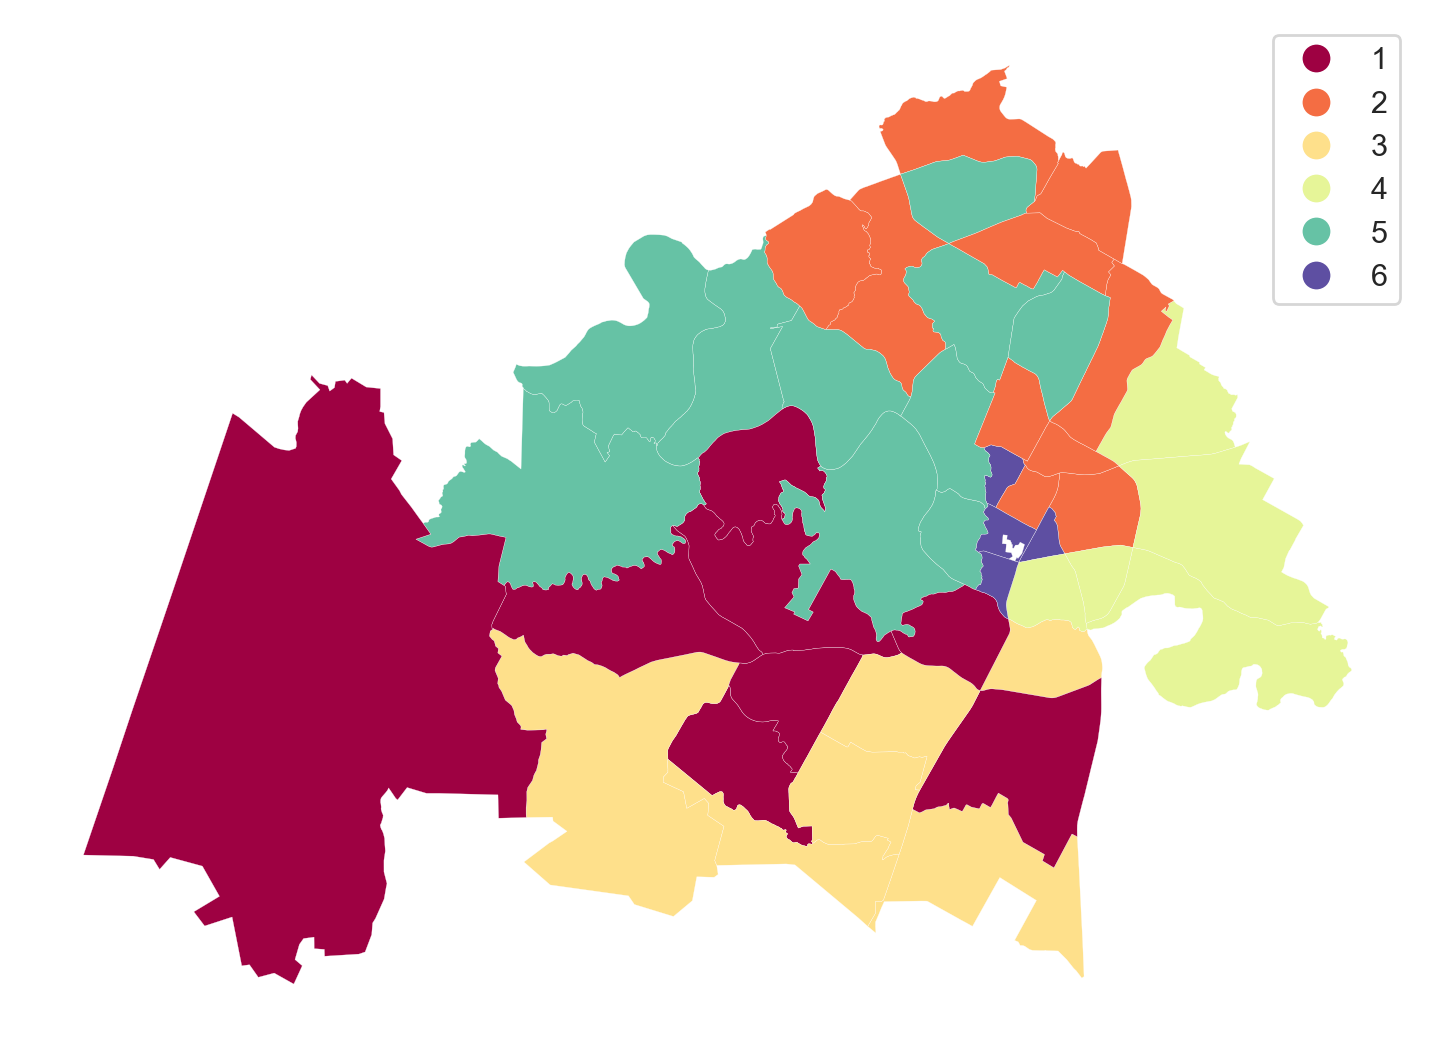

In [99]:
# Visualizamos el mapa
f, ax = plt.subplots(1, figsize = (9, 9), dpi = 200)

zrt.plot(column = 'resultados', categorical = True, legend = True, linewidth = 0.1, 
      edgecolor = 'white', ax = ax, cmap = "Spectral")

ax.set_axis_off()

plt.show()

Ahora vamos a ver el puntaje por área

In [100]:
zrt[ratings + ["resultados"]].groupby("resultados").mean().T

resultados,1,2,3,4,5,6
review_scores_rating,97.496464,95.980336,93.358554,92.652638,94.426676,94.860229
review_scores_accuracy,9.779766,9.575788,9.757166,9.386422,9.568451,9.640364
review_scores_cleanliness,9.621446,9.674461,8.940497,9.291327,9.512233,9.404633
review_scores_checkin,9.934696,9.893921,9.883711,9.695036,9.741366,9.800524
review_scores_communication,9.931442,9.873011,9.920385,9.711128,9.799383,9.821388
review_scores_location,9.668293,9.427098,9.146040,8.746191,9.558437,9.617159
review_scores_value,9.764603,9.615850,9.721866,9.301172,9.399363,9.415500


# Referencias
- Duque, J. C., Anselin, L., &; Rey, S. J. (2011). The MAX-P-regions problem*. Journal of Regional Science, 52(3), 397–419. https://doi.org/10.1111/j.1467-9787.2011.00743.x 
- Rey, S., & Arribas-Bel, D. (nd). Introduction Geographic Data Science with PySAL and the pydata stack
